
# Music Generation with RNNs

Building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

## 2.1 Dependencies 
First, install dependencies, and import the relevant packages we'll need.

In [2]:
pip install regex

     |████████████████████████████████| 655kB 57.5MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp27-cp27mu-linux_x86_64.whl size=531864 sha256=beab6aadf6e433b064ee5fffc2b6447e82e145d645a99463796a60f11a4b617e
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [0]:
import tensorflow as tf 
tf.enable_eager_execution()

%load util.py
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay

is_correct_tf_version = '1.14.0' in tf.__version__
assert is_correct_tf_version, "Wrong tensorflow version ({}) installed".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled,      "Tensorflow eager mode is not enabled"

'''If this does not return true on Colaboratory, 
    go to runtime -> change runtime type -> GPU
    or see a TA'''
assert tf.test.is_gpu_available()

!apt-get install abcmidi timidity > /dev/null 2>&1

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

Let's download the dataset of thousands of Irish folk songs, represented in the ABC notation.

In [4]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/divensambhwani/Music_Generation/master/data/irish.abc')

212992/197618 [================================] - 0s 0us/step


### Inspect the dataset

We can take a look and listen to get a better sense of the dataset:

In [5]:
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 197618 characters


In [7]:
# Take a look at the first 250 characters in text
print(text[:250])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [8]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

83 unique characters


<!-- TODO: here explanation of the one-hot encoding, getting the unique characters in the file -->

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
text_as_int = np.array([char2idx[c] for c in text])

''' Create a mapping from indices to characters'''
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [10]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '!' :   2,
  ' ' :   1,
  '#' :   4,
  '"' :   3,
  "'" :   5,
  ')' :   7,
  '(' :   6,
  '-' :   9,
  ',' :   8,
  '/' :  11,
  '.' :  10,
  '1' :  13,
  '0' :  12,
  '3' :  15,
  '2' :  14,
  '5' :  17,
  '4' :  16,
  '7' :  19,
  '6' :  18,
  ...
}


We can also look at how the first part of the text is mapped to an integer representation:

In [11]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'X:1\nT:Alexand' ---- characters mapped to int ---- > [49 22 13  0 45 22 26 67 60 79 56 69 59]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell", and the target sequence "ello".

First, use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices. This is a function within `tf.data` which is generally useful for importing data.

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
# Note how we are using the `tf.data` module!
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)


Next, we need to define the input and target texts for each sequence. 

Define a function to do this, and then use the [`map`](http://book.pythontips.com/en/latest/map_filter.html) method to apply a simple function to each batch. 

In [0]:

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

''' use the map method to apply your function to the list of sequences to generate the dataset!'''
dataset = sequences.map(split_input_target)

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the `RNN` considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [14]:
for input_example, target_example in dataset.take(1):
  
  for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
      print("Step {:4d}".format(i))
      print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
      print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 49 ('X')
  expected output: 22 (':')
Step    1
  input: 22 (':')
  expected output: 13 ('1')
Step    2
  input: 13 ('1')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 45 ('T')
Step    4
  input: 45 ('T')
  expected output: 22 (':')


### Create training batches

Great! Now we have our text split into sequences of manageable size. But before we actually feed this data into our model, we'll [`shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the data (for the purpose of stochastic gradient descent) and then pack it into batches which will be used during training.

In [15]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Examine the dimensions of the dataset
dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

We'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


### Define the RNN model

Let's define some important dimensions:

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# The number of RNN units
rnn_units = 1024

Now, we can define the function that will be used to actually build the model. 

In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
  return_sequences=True, 
  recurrent_initializer='glorot_uniform',
  stateful=True
)

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
    tf.keras.layers.Dense(vocab_size) 
  ])

  return model

In [0]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)


### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21248     
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (64, None, 1024)          5251072   
_________________________________________________________________
dense (Dense)                (64, None, 83)            85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [21]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(64), Dimension(100), Dimension(83)]), '# (batch_size, sequence_length, vocab_size)')


### Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. We have the previous state of the RNN as well as the input at a given time step, and want to predict the class of the next character, that is, actually predict the next character. 

So, to train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets and the predicted targets.

Let's first compute the loss using our example predictions from the untrained model: 

In [ ]:
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Now we are ready to define our training operation, i.e., our optimizer and duration of training, and actually train the model.

We will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss!

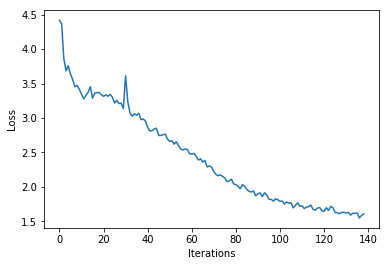

N/A%|#                                              |Time:  0:00:02  Loss: 1.54


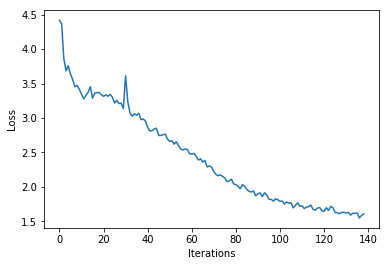

In [23]:
# Training step
EPOCHS = 5 

optimizer = tf.train.AdamOptimizer() 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

history = []
plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
for epoch in range(EPOCHS):

    # Initialize the hidden state at the start of every epoch; initially is None
    hidden = model.reset_states()
    
    # Enumerate the dataset for use in training
    custom_msg = util.custom_progress_text("Loss: %(loss)2.2f")
    bar = util.create_progress_bar(custom_msg)
    for inp, target in bar(dataset):
        # Use tf.GradientTape()
        with tf.GradientTape() as tape:
            
            predictions = model(inp) 
        
            loss = compute_loss(target, predictions) 
        
        # Now, compute the gradients and try to minimize
        
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update the progress bar!
        history.append(loss.numpy().mean())
        custom_msg.update_mapping(loss=history[-1])
        plotter.plot(history)
    
    # Update the model with the changed weights!
    model.save_weights(checkpoint_prefix.format(epoch=epoch))



## 2.5 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive caharacters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (1, None, 1024)           5251072   
_________________________________________________________________
dense_1 (Dense)              (1, None, 83)             85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


Notice how now in our `model.summary` the first dimension of the output shape is 1. This is because we have fed in a fixed `batch_size` of 1.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution of the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state returned is fed back into the model, so that it now has more context. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.



In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  bar = util.create_progress_bar()
  for i in bar(range(generation_length)):
      '''evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval) 
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''use a multinomial distribution to sample'''
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy() 
      
      # Pass the prediction along with the previous hidden state
          # as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      

      # convert back to char
      text_generated.append(idx2char[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [27]:

# As you may notice, ABC files start with "X" - this may be a good start string
text = generate_text(model, start_string="X")

N/A%|                                                         |ETA:  --:--:--  WARNING: Logging before flag parsing goes to stderr.
W0924 16:41:09.316246 140453518374784 deprecation.py:323] From <ipython-input-26-7ca06ff4ce57>:22: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.
100%|#########################################################|Time:  0:00:05  


### Play back the generated music!


In [ ]:
util.play_generated_song(text)

In [28]:
print(text)

X5
:1/8
K:D Major
GGGBA ced2|ede2 gfed|feed edff|efdc edce|BAFF E2:|!
c|A2A edf g3|a2 g2 ced e2 d2h:s1
K:C
L:1/8
K:C MajoridF cEFD:|BAGF GAFA|D2Bc d2el|!
faf|ed^c d2b|a2g e4:|!
Bdd B3|f2fe dBcB|BdBc BABc|faaf g3:|!
A|def fef|fef efg|dBA Bdef|dag2 f'edc dBGF|BAG2 Bded|!
]]!

X:207
T:Delnin 
G|ddB d3|!
ded ecAB|deff ecAA|d2AB defg|!
c2d^c dABc|A2ce dcBc|[2F GBAF|EDGE EFAG|!

G2FD F2EA|AAFA EDFc|A2dBA GAAG|ABdc dBAGE|GGE2C/8
:69
T:Dwllnhu's
Z: id:dc-reel-24M65
M:C|
L:1/8
K:DG Majoy

dB|d2dc AcBA|Gded g3:|!
d2|ceef gfga|fedB AdBc|BdBe d3|]!
BA|dag ffd|fef e2d|c3 A3|!
d2 f2g gfe|dBc dBGF|EGFG B2:|!

X:88
T:2roar'
t Mas toy
Z:|id:G/cAB|cdc A2:G|!
ABA c2B|dde c2B2|G3 AFE|!
DAG BAG EE|A2 G2
GF|A2 B2 A2|AcA G2:|!

X:18
T:Firgee clolsl's apol
Z: id:dc-hopil-i33
M:C|
L:1/8
K:D Major
A|G2AF ABAA|Adcd gaaf g2BA1 (Bcd2 (fefg|e3A AGFE|EdBf d2GEA|D2dc ecAd|!
B2de fefg|d2ef A3:|!
A|A2F2 E2d2|edef dBBG|EDFD d3B|cAFA G2E:|!
d|dcBd c2ed|BcA2 fdge g2gf|a2ab bfge|dBg2 dfgg|e'fef g3e|dAGA GAGE|!
Bdd^22 edcA|